In [1]:
# %% imports and setting up
from os import chdir as setwd 
from os import getcwd as getcwd

# setting working directory
user = "TS"  # <-- type your initials here
work_dir = ""

# add the file path to the repo on your machine
if user == "TS":
    work_dir = "C:/Users/t-sut/Documents/Monash/Monash2022/Sem2/FIT3164/" + \
                "ds08_renewable_energy_scheduling/"
elif user == "JK":
    work_dir = "C:/Users/jjaso/Documents/ds08_renewable_energy_scheduling/"
elif user == "JS": 
    work_dir = "/Users/jasonnathaniel/Documents/Monash University/Sem 2 2022/" + \
                "FIT3164 Data science project 2/ds08_renewable_energy_scheduling/"

setwd(work_dir)
print("Current working directory: ", getcwd())

# import data science libraries
import matplotlib.pyplot as plt
import pandas as pd
import util_data_loader as dl
import util_data_cleaning as clean
from util_MASE import mase 
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

Current working directory:  C:\Users\t-sut\Documents\Monash\Monash2022\Sem2\FIT3164\ds08_renewable_energy_scheduling


# Read, clean and reshape data

In [2]:
# %% Read and clean power data
# using phase 2 data as it's the same as phase 1, but for more time stamps
powr = dl.convert_tsf_to_dataframe("rawdata/nov_data.tsf")[0]

# clean and reshape
boundary = pd.to_datetime("2020-10-31 23:59:59", format = "%Y-%m-%d %H:%M:%S")
train, test = clean.extract_data(powr, split_timestamp = boundary)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [3]:
# %% load era5 data
era5 = pd.read_csv("rawdata/ERA5_Weather_Data_Monash.csv")
era5["datetime (UTC)"] = pd.to_datetime(era5["datetime (UTC)"], 
                                        format = "%Y-%m-%d %H:%M:%S")

In [4]:
# %% match by timestamp - takes a bit
train = clean.concat_power_weather(train, era5)
test = clean.concat_power_weather(test, era5)

In [5]:
# select only relevant cols
era5_cols = ['temperature', 'dewpoint_temperature', 'wind_speed', 
             'mean_sea_level_pressure', 'relative_humidity', 
             'surface_solar_radiation', 'surface_thermal_radiation', 
             'total_cloud_cover']

train_feat = train[era5_cols]
train_target = train.drop(era5_cols, axis = 1)
train_times = train.timestamp
train_target.drop("timestamp", inplace = True, axis = 1)

test_feat = test[era5_cols]
test_target = test.drop(era5_cols, axis = 1)
test_times = test.timestamp
test_target.drop("timestamp", inplace = True, axis = 1)

### Cosine/Sine of timestamp

In [6]:
def fourier_ts(timestamp):
    interval_in_day = (timestamp.hour*60 + timestamp.minute)/15 # minute of day / 15
    return np.cos(interval_in_day*np.pi/48), np.sin(interval_in_day*np.pi/48)

def is_weekday(timestamp):
    if timestamp.day_of_week <= 4:
        return 1
    else:
        return 0

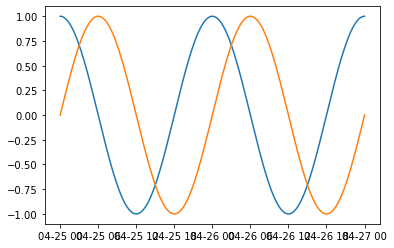

In [7]:
day_idxs = range(0, 96*2)
start_ts = pd.to_datetime("2020-04-25 00:00:00", format = "%Y-%m-%d %H:%M:%S")
x = [start_ts]
for i in day_idxs:
    x.append(x[-1] + pd.Timedelta(minutes = 15))
y = [fourier_ts(x_) for x_ in x]
plt.plot(x, y)

In [8]:
train_ts = pd.DataFrame([fourier_ts(x_) for x_ in train_times])
test_ts = pd.DataFrame([fourier_ts(x_) for x_ in test_times])

train_day_in_week = pd.DataFrame([is_weekday(x_) for x_ in train_times])
test_day_in_week = pd.DataFrame([is_weekday(x_) for x_ in test_times])

In [9]:
train_f = pd.concat([train_feat, train_ts, train_day_in_week], axis = 1)
test_f = pd.concat([test_feat, test_ts, test_day_in_week], axis = 1)

In [10]:
# reshape data as 3D array of shape (out_rows, window, ncol)
# out_rows = data.shape[0] - window + 1 - ie the number of rows after gathering past predictions into each row
# window is the number of previous timestamps to consider
# ncol = data.shape[1]

window = 16 # past 4 hours of data
# window of 96 is too large
# window of 16 is ok

train_feat_3d = []
# train_target_3d = []
for i in range(window, train_f.shape[0]):#train_feat.shape[0]):
    rows = range((i-window), i)
    train_feat_3d.append(train_f.iloc[rows])#train_feat.iloc[rows])
#     train_target_3d.append(train_target.iloc[rows])
    
train_feat_3d = np.array(train_feat_3d)
# train_target_3d = np.array(train_feat_3d)

# test_days = test.shape[0]//96
test_feat_3d = []
# append the last window observations from train_feat to test_feat
test_feat_temp = train_f.iloc[-window:, :].append(test_f)#train_feat.iloc[-window:,:].append(test_feat)
# test_target_3d = []
for i in range(window, test_feat_temp.shape[0]):
    rows = range((i-window), i)
    test_feat_3d.append(test_feat_temp.iloc[rows])
#     test_target_3d.append(test_target.iloc[rows])
    
test_feat_3d = np.array(test_feat_3d)
# test_target_3d = np.array(test_feat_3d)

In [74]:
# take previous observation away current observation
train_diff = np.zeros_like(train_target)
for i in range(1, train_target.shape[0]):
    train_diff[i] = train_target.iloc[i, :] - train_target.iloc[i-1, :]
    
train_diff = pd.DataFrame(train_diff)
# train_diff.columns = train_target.columns
cols = []
for i in range(train_diff.shape[1]):
    col = train_target.columns[i]
    col += "_diff"
    cols.append(col)
    
train_diff.columns = cols

In [75]:
# take previous observation away current observation
test_diff = np.zeros_like(test_target)
for i in range(1, test_target.shape[0]):
    test_diff[i] = test_target.iloc[i, :] - test_target.iloc[i-1, :]
    
test_diff = pd.DataFrame(test_diff)
# train_diff.columns = train_target.columns
cols = []
for i in range(test_diff.shape[1]):
    col = test_target.columns[i]
    col += "_diff"
    cols.append(col)
    
test_diff.columns = cols

In [79]:
train_f_diff = pd.concat([train_f, train_diff], axis = 1)
test_f_diff = pd.concat([test_f, test_diff], axis = 1)

# Model

### Clear-sky model
Create and fit a clear-sky model to account for the daily cycling in the data, then take this component out of the main data so that the ML model only needs to learn the vairations from this base cycle

In [11]:
def cs_model(timestamp):
    day_of_year = timestamp.day_of_year 
    interval_in_day = (timestamp.hour*60 + timestamp.minute)/15 # minute of day / 15
    return np.cos(2*np.pi*((day_of_year+8)*96 + interval_in_day/96)) # change 17520 so that it wraps around?

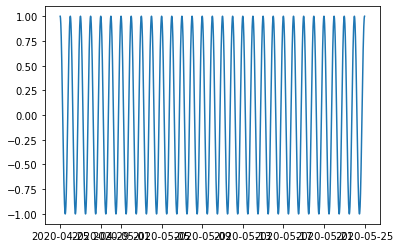

In [12]:
day_idxs = range(0, 96*30)
start_ts = pd.to_datetime("2020-04-25 00:00:00", format = "%Y-%m-%d %H:%M:%S")
x = [start_ts]
for i in day_idxs:
    x.append(x[-1] + pd.Timedelta(minutes = 15))
y = [cs_model(x_) for x_ in x]
plt.plot(x, y)

In [13]:
# take model away from each TS


### ML model
To learn the variations - LSTM or convolutional autoencoder? Basic dense-net might work too

In [93]:
# %% define model
ncol = train_f.shape[1] #train_feat.shape[1]#train_feat_3d.shape[2] 
output_shape = train_target.shape[1]

# trying an LSTM model with reduced latent space and batch normalisation
inpt = keras.layers.Input(shape = ncol) #keras.layers.Input(shape = (window, ncol))

# fourier_inpt = keras.layers.Input(shape = 2, name = "fourier_terms")

# inpt = keras.layers.Concatenate()([feature_inpt, fourier_inpt])

# conv_1 = keras.layers.Conv1D(filters = 8, kernel_size = 2, strides = 2)(inpt)
# norm_1 = keras.layers.BatchNormalization()(conv_1)
# conv_2 = keras.layers.Conv1D(filters = 8, kernel_size = 2, strides = 2)(norm_1)
# norm_2 = keras.layers.BatchNormalization()(conv_2)
# lstm = keras.layers.LSTM(units = 6)(norm_2)
# decoder_in = keras.layers.Dense(4, activation = "relu")(lstm)
# x = keras.layers.Dense(8, activation = "relu")(decoder_in)

norm = keras.layers.BatchNormalization()(inpt)
x = keras.layers.Reshape((1, ncol))(norm)
x = keras.layers.LSTM(ncol)(x) #(norm)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(ncol*2, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(ncol*4, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(output_shape*4, activation="tanh")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(output_shape*2, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Flatten()(x)
output = keras.layers.Dense(output_shape)(x)

LSTM = keras.Model(inputs=inpt, outputs=output)

LSTM.compile(optimizer = "adam",
             loss = "MeanSquaredError",
             metrics = ["MeanAbsoluteError", "MeanAbsolutePercentageError"])

LSTM.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 11)]              0         
                                                                 
 batch_normalization_48 (Bat  (None, 11)               44        
 chNormalization)                                                
                                                                 
 reshape_8 (Reshape)         (None, 1, 11)             0         
                                                                 
 lstm_8 (LSTM)               (None, 11)                1012      
                                                                 
 batch_normalization_49 (Bat  (None, 11)               44        
 chNormalization)                                                
                                                                 
 dense_40 (Dense)            (None, 22)                264 

In [94]:
ES = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                   patience = 20,
                                   restore_best_weights = True)

LR = keras.callbacks.ReduceLROnPlateau(patience = 15)

TB = keras.callbacks.TensorBoard()

history = LSTM.fit(train_f, 
         train_target,
         epochs = 1000,
         batch_size = 96, # treat one day as a batch
         callbacks = [TB, ES, LR], # ES
         validation_split = 0.2,
         shuffle = True,
         verbose = 1
        ).history

Epoch 1/1000
152/152 [==============================] - 6s 12ms/step - loss: 15858.6387 - mean_absolute_error: 51.0161 - mean_absolute_percentage_error: 289709408.0000 - val_loss: 12358.3096 - val_mean_absolute_error: 44.5960 - val_mean_absolute_percentage_error: 45309448.0000 - lr: 0.0010
Epoch 2/1000
152/152 [==============================] - 1s 7ms/step - loss: 15457.8848 - mean_absolute_error: 50.3668 - mean_absolute_percentage_error: 323769664.0000 - val_loss: 11847.2158 - val_mean_absolute_error: 43.3280 - val_mean_absolute_percentage_error: 104458448.0000 - lr: 0.0010
Epoch 3/1000
152/152 [==============================] - 1s 6ms/step - loss: 14835.2402 - mean_absolute_error: 49.1023 - mean_absolute_percentage_error: 275571456.0000 - val_loss: 12183.3516 - val_mean_absolute_error: 44.1435 - val_mean_absolute_percentage_error: 132816552.0000 - lr: 0.0010
Epoch 4/1000
152/152 [==============================] - 1s 6ms/step - loss: 14025.8613 - mean_absolute_error: 47.4708 - mean_ab

152/152 [==============================] - 1s 6ms/step - loss: 235.7289 - mean_absolute_error: 5.7983 - mean_absolute_percentage_error: 229559040.0000 - val_loss: 658.3021 - val_mean_absolute_error: 8.4272 - val_mean_absolute_percentage_error: 156312480.0000 - lr: 0.0010
Epoch 30/1000
152/152 [==============================] - 1s 6ms/step - loss: 230.7597 - mean_absolute_error: 5.7112 - mean_absolute_percentage_error: 232171216.0000 - val_loss: 642.3186 - val_mean_absolute_error: 8.1263 - val_mean_absolute_percentage_error: 160307872.0000 - lr: 0.0010
Epoch 31/1000
152/152 [==============================] - 1s 5ms/step - loss: 229.9720 - mean_absolute_error: 5.6866 - mean_absolute_percentage_error: 231112640.0000 - val_loss: 666.0581 - val_mean_absolute_error: 8.3889 - val_mean_absolute_percentage_error: 155098704.0000 - lr: 0.0010
Epoch 32/1000
152/152 [==============================] - 1s 5ms/step - loss: 230.8297 - mean_absolute_error: 5.6955 - mean_absolute_percentage_error: 232888

Epoch 58/1000
152/152 [==============================] - 1s 5ms/step - loss: 205.2138 - mean_absolute_error: 5.4061 - mean_absolute_percentage_error: 226557792.0000 - val_loss: 681.9446 - val_mean_absolute_error: 8.3742 - val_mean_absolute_percentage_error: 152498656.0000 - lr: 0.0010
Epoch 59/1000
152/152 [==============================] - 1s 5ms/step - loss: 210.2462 - mean_absolute_error: 5.4526 - mean_absolute_percentage_error: 226983424.0000 - val_loss: 632.2235 - val_mean_absolute_error: 7.8551 - val_mean_absolute_percentage_error: 156308848.0000 - lr: 0.0010
Epoch 60/1000
152/152 [==============================] - 1s 5ms/step - loss: 199.8960 - mean_absolute_error: 5.3428 - mean_absolute_percentage_error: 227396032.0000 - val_loss: 651.2863 - val_mean_absolute_error: 8.1486 - val_mean_absolute_percentage_error: 143812224.0000 - lr: 0.0010
Epoch 61/1000
152/152 [==============================] - 1s 5ms/step - loss: 205.1541 - mean_absolute_error: 5.4096 - mean_absolute_percentage

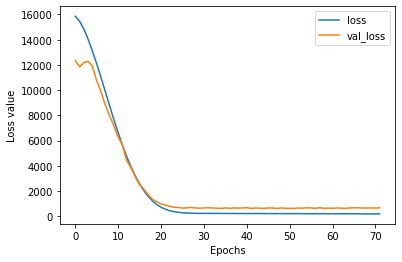

In [95]:
plt.plot(history.get("loss"), label = "loss")
plt.plot(history.get("val_loss"), label = "val_loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.show()

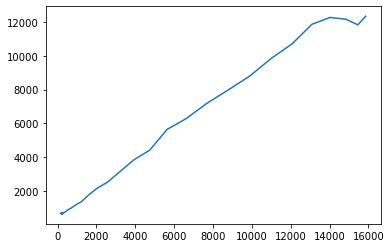

In [96]:
plt.plot(history.get("loss"), history.get("val_loss"))

# Evaluate on test set

90/90 [==============================] - 1s 2ms/step


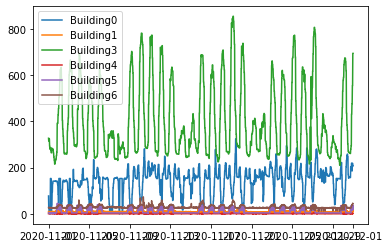

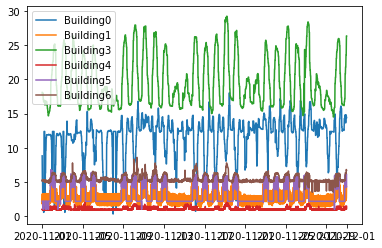

In [97]:
results = LSTM.predict(test_f)

rmse = np.sqrt(test_target, results)#.numpy()
mae = keras.losses.mean_absolute_error(test_target, results).numpy()


# plot building TSs
for col in range(6): 
    plt.plot(test_times, test_target.iloc[:,col], label = test_target.columns[col])
plt.legend()
plt.show()

for col in range(6): 
    plt.plot(test_times, results[:, col], label = test_target.columns[col])
plt.legend()
plt.show()

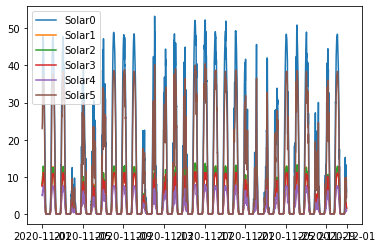

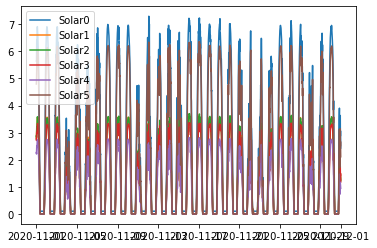

In [98]:
# plot solar TSs
for col in range(6, 12): 
    plt.plot(test_times, test_target.iloc[:,col], label = test_target.columns[col])
plt.legend()
plt.show()

for col in range(6, 12): 
    plt.plot(test_times, results[:, col], label = test_target.columns[col])
plt.legend()
plt.show()

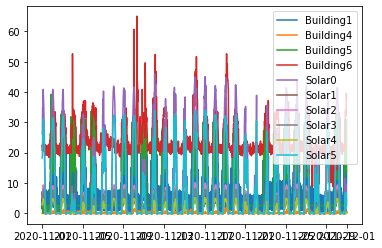

In [99]:
# plot differences - removing building 0 and 3 as they are really off
for col in [1,3,4,5,6,7,8,9,10,11]: # range(test_target.shape[1]): 
    plt.plot(test_times, test_target.iloc[:,col] - results[:, col], label = test_target.columns[col])
plt.legend()
plt.show()

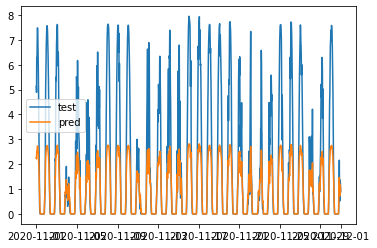

In [100]:
plt.plot(test_times, test_target.loc[:,"Solar4"], label = "test")
plt.plot(test_times, results[:, 10], label = "pred")
plt.legend()
plt.show()

In [101]:
eval_data = np.array(train.append(test).drop(era5_cols + ["timestamp"], axis=1))
for i in range(test_target.shape[1]): # for each col
    col_name = test_target.columns[i]
    err = mase(results[:, i], eval_data[:, i], 2688)#results.iloc[:, i], eval_data.iloc[:, i], 2688)
    print(f"MASE of {col_name}: {err}")

MASE of Building0: 3.486279944842065
MASE of Building1: 6.522210771547618
MASE of Building3: 10.780881931508885
MASE of Building4: 0.3534945366356471
MASE of Building5: 1.9406895315518191
MASE of Building6: 9.878945729843027
MASE of Solar0: 2.637765770537707
MASE of Solar1: 1.1631055548784417
MASE of Solar2: 1.5494127799687776
MASE of Solar3: 1.8283076566063077
MASE of Solar4: 1.4372287432531976
MASE of Solar5: 2.1503492621672295


Note: adding ```keras.layers.Conv1D``` before the LSTM layer degrades MASE for all time series - BUT across the board learns the daily peaking pattern better (but not the nightly lows)

```keras.layers.BatchNormalization``` increases adherance to daily pattern of peaks and trough

Reconstructing buildings 1 and 3 happens best with early stopping - but all other TSs reconstruct worse :(

Buildings reconstruct best with low epoch count

Solar panels reconstruct best with high epoch count

In [155]:
LSTM.save("forecasting/saved_models")

INFO:tensorflow:Assets written to: forecasting/saved_models\assets


INFO:tensorflow:Assets written to: forecasting/saved_models\assets


# Modelling buildings only

In [156]:
train_buildings = train_target.iloc[:, :6]
test_buildings = test_target.iloc[:, :6]

In [157]:
# %% define model
ncol = train_f.shape[1] # train_feat_3d.shape[2]
output_shape = train_buildings.shape[1]

# trying an LSTM model with reduced latent space and batch normalisation
# play around with LSTM location - current design might be a bit big
inpt = keras.layers.Input(shape = ncol) # inpt = keras.layers.Input(shape = (window, ncol))
norm = keras.layers.BatchNormalization()(inpt)
x = keras.layers.Reshape((1, ncol))(norm)
x = keras.layers.LSTM(ncol)(x)
x = keras.layers.Dense(ncol*2, activation="relu")(x)
x = keras.layers.Dense(ncol*4, activation="relu")(x)
x = keras.layers.Dense(output_shape*4, activation="tanh")(x)
x = keras.layers.Dense(output_shape*2, activation="relu")(x)
# x = keras.layers.Flatten()(x)
output = keras.layers.Dense(output_shape)(x)

LSTM_buildings = keras.Model(inputs=inpt, outputs=output)

LSTM_buildings.compile(optimizer = "adam",
             loss = "MeanSquaredError",
             metrics = ["MeanAbsoluteError", "MeanAbsolutePercentageError"])

LSTM_buildings.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 11)]              0         
                                                                 
 batch_normalization_43 (Bat  (None, 11)               44        
 chNormalization)                                                
                                                                 
 reshape_13 (Reshape)        (None, 1, 11)             0         
                                                                 
 lstm_13 (LSTM)              (None, 11)                1012      
                                                                 
 dense_65 (Dense)            (None, 22)                264       
                                                                 
 dense_66 (Dense)            (None, 44)                1012      
                                                          

In [158]:
ES = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                   patience = 20,
                                   restore_best_weights = True)

LR = keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", patience = 15)

TB = keras.callbacks.TensorBoard()

history = LSTM_buildings.fit(train_f, 
                             train_buildings,
                             epochs = 1000,
                             batch_size = 96, # treat one day as a batch
                             callbacks = [TB, ES, LR],
                             validation_split = 0.2,
                             shuffle = True,
                             verbose = 1).history

Epoch 1/1000
152/152 [==============================] - 3s 7ms/step - loss: 30870.3262 - mean_absolute_error: 95.8829 - mean_absolute_percentage_error: 80.8850 - val_loss: 21680.0703 - val_mean_absolute_error: 75.0735 - val_mean_absolute_percentage_error: 68.7873 - lr: 0.0010
Epoch 2/1000
152/152 [==============================] - 1s 4ms/step - loss: 26988.4258 - mean_absolute_error: 85.9337 - mean_absolute_percentage_error: 67.9047 - val_loss: 18024.8164 - val_mean_absolute_error: 66.3918 - val_mean_absolute_percentage_error: 103.6772 - lr: 0.0010
Epoch 3/1000
152/152 [==============================] - 1s 3ms/step - loss: 22115.6582 - mean_absolute_error: 75.9806 - mean_absolute_percentage_error: 67.1720 - val_loss: 13779.5127 - val_mean_absolute_error: 56.5401 - val_mean_absolute_percentage_error: 146.4084 - lr: 0.0010
Epoch 4/1000
152/152 [==============================] - 1s 5ms/step - loss: 16782.1172 - mean_absolute_error: 63.5875 - mean_absolute_percentage_error: 64.4011 - val_l

Epoch 31/1000
152/152 [==============================] - 1s 4ms/step - loss: 535.6296 - mean_absolute_error: 10.8953 - mean_absolute_percentage_error: 49.5217 - val_loss: 1321.7999 - val_mean_absolute_error: 15.5349 - val_mean_absolute_percentage_error: 192.5786 - lr: 0.0010
Epoch 32/1000
152/152 [==============================] - 1s 4ms/step - loss: 509.7813 - mean_absolute_error: 10.6663 - mean_absolute_percentage_error: 48.3731 - val_loss: 1332.7942 - val_mean_absolute_error: 15.9524 - val_mean_absolute_percentage_error: 186.9310 - lr: 0.0010
Epoch 33/1000
152/152 [==============================] - 1s 4ms/step - loss: 506.6056 - mean_absolute_error: 10.6095 - mean_absolute_percentage_error: 48.0290 - val_loss: 1266.5929 - val_mean_absolute_error: 15.2939 - val_mean_absolute_percentage_error: 175.0120 - lr: 0.0010
Epoch 34/1000
152/152 [==============================] - 1s 4ms/step - loss: 481.6834 - mean_absolute_error: 10.4095 - mean_absolute_percentage_error: 47.2968 - val_loss: 1

Epoch 61/1000
152/152 [==============================] - 1s 4ms/step - loss: 427.8976 - mean_absolute_error: 9.6865 - mean_absolute_percentage_error: 43.1123 - val_loss: 1239.2817 - val_mean_absolute_error: 15.0267 - val_mean_absolute_percentage_error: 118.1085 - lr: 0.0010
Epoch 62/1000
152/152 [==============================] - 1s 4ms/step - loss: 430.5920 - mean_absolute_error: 9.7068 - mean_absolute_percentage_error: 43.4464 - val_loss: 1202.0204 - val_mean_absolute_error: 14.4458 - val_mean_absolute_percentage_error: 118.9029 - lr: 0.0010
Epoch 63/1000
152/152 [==============================] - 1s 4ms/step - loss: 428.1725 - mean_absolute_error: 9.6617 - mean_absolute_percentage_error: 43.1816 - val_loss: 1219.7278 - val_mean_absolute_error: 14.7129 - val_mean_absolute_percentage_error: 116.4368 - lr: 0.0010
Epoch 64/1000
152/152 [==============================] - 1s 4ms/step - loss: 428.0865 - mean_absolute_error: 9.6511 - mean_absolute_percentage_error: 43.7555 - val_loss: 1290.

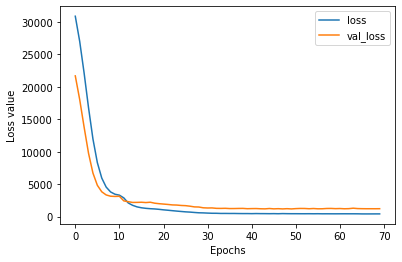

In [159]:
plt.plot(history.get("loss"), label = "loss")
plt.plot(history.get("val_loss"), label = "val_loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.show()

In [160]:
results = LSTM_buildings.predict(test_f)
eval_data = np.array(train.append(test).drop(era5_cols + ["timestamp"], axis=1))
for i in range(test_buildings.shape[1]): # for each col
    col_name = test_buildings.columns[i]
    err = mase(results[:, i], eval_data[:, i], 2688)
    print(f"MASE of {col_name}: {err}")

90/90 [==============================] - 0s 2ms/step
MASE of Building0: 1.0015036296384936
MASE of Building1: 4.498342181699325
MASE of Building3: 2.289223898758046
MASE of Building4: 1.0134984711965722
MASE of Building5: 1.5564814760201202
MASE of Building6: 2.4343561208363913


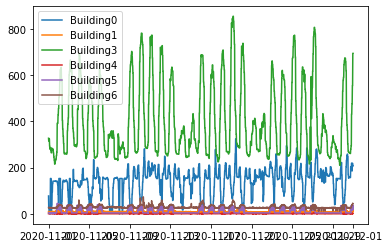

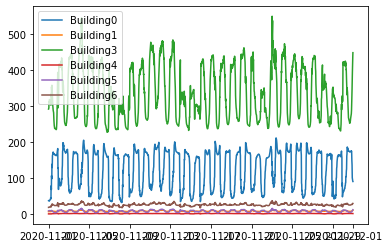

In [161]:
# plot building TSs
for col in range(6): 
    plt.plot(test_times, test_buildings.iloc[:,col], label = test_target.columns[col])
plt.legend()
plt.show()

for col in range(6): 
    plt.plot(test_times, results[:, col], label = test_target.columns[col])
plt.legend()
plt.show()

# Modelling solar panels only

In [168]:
train_solar = train_target.iloc[:, 6:]
test_solar = test_target.iloc[:, 6:]

In [169]:
# %% define model
ncol = train_f.shape[1]-1 # train_feat_3d.shape[2]
output_shape = train_solar.shape[1]

# trying an LSTM model with reduced latent space and batch normalisation
# play around with LSTM location - current design might be a bit big
inpt = keras.layers.Input(shape = ncol) # inpt = keras.layers.Input(shape = (window, ncol))
norm = keras.layers.BatchNormalization()(inpt)
x = keras.layers.Reshape((1, ncol))(norm)
x = keras.layers.LSTM(ncol)(x)
x = keras.layers.Dense(ncol//2, activation="relu")(x)
x = keras.layers.Dense(ncol//4, activation="relu")(x)
x = keras.layers.Dense(output_shape*4, activation="tanh")(x)
x = keras.layers.Dense(output_shape*2, activation="relu")(x)
# x = keras.layers.Flatten()(x)
output = keras.layers.Dense(output_shape)(x)

LSTM_solar = keras.Model(inputs=inpt, outputs=output)

LSTM_solar.compile(optimizer = "adam",
             loss = "MeanAbsoluteError",
             metrics = ["MeanSquaredError", "MeanAbsolutePercentageError"])

LSTM_solar.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 10)]              0         
                                                                 
 batch_normalization_46 (Bat  (None, 10)               40        
 chNormalization)                                                
                                                                 
 reshape_16 (Reshape)        (None, 1, 10)             0         
                                                                 
 lstm_16 (LSTM)              (None, 10)                840       
                                                                 
 dense_80 (Dense)            (None, 5)                 55        
                                                                 
 dense_81 (Dense)            (None, 2)                 12        
                                                          

In [171]:
ES = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                   patience = 100,
                                   restore_best_weights = True)

LR = keras.callbacks.ReduceLROnPlateau(patience = 15)

TB = keras.callbacks.TensorBoard()

history = LSTM_solar.fit(train_f.iloc[:, :-1], 
                         train_solar,
                         epochs = 1000,
                         batch_size = 96, # treat one day as a batch
                         callbacks = [TB, ES, LR],
                         validation_split = 0.2,
                         shuffle = True,
                         verbose = 1).history

Epoch 1/1000
152/152 [==============================] - 2s 5ms/step - loss: 2.5268 - mean_squared_error: 35.3403 - mean_absolute_percentage_error: 16361899.0000 - val_loss: 4.3255 - val_mean_squared_error: 87.2771 - val_mean_absolute_percentage_error: 11872339.0000 - lr: 0.0010
Epoch 2/1000
152/152 [==============================] - 0s 3ms/step - loss: 2.0310 - mean_squared_error: 26.6579 - mean_absolute_percentage_error: 54489560.0000 - val_loss: 2.9160 - val_mean_squared_error: 52.8137 - val_mean_absolute_percentage_error: 3458015.2500 - lr: 0.0010
Epoch 3/1000
152/152 [==============================] - 1s 4ms/step - loss: 1.5033 - mean_squared_error: 14.3873 - mean_absolute_percentage_error: 127279624.0000 - val_loss: 2.1986 - val_mean_squared_error: 29.7297 - val_mean_absolute_percentage_error: 2578303.2500 - lr: 0.0010
Epoch 4/1000
152/152 [==============================] - 1s 4ms/step - loss: 1.3415 - mean_squared_error: 10.4349 - mean_absolute_percentage_error: 167046704.0000 - 

152/152 [==============================] - 1s 4ms/step - loss: 1.1474 - mean_squared_error: 7.7674 - mean_absolute_percentage_error: 158896368.0000 - val_loss: 1.5286 - val_mean_squared_error: 12.9013 - val_mean_absolute_percentage_error: 413475.6562 - lr: 1.0000e-06
Epoch 60/1000
152/152 [==============================] - 1s 4ms/step - loss: 1.1567 - mean_squared_error: 7.8829 - mean_absolute_percentage_error: 161171712.0000 - val_loss: 1.5291 - val_mean_squared_error: 12.9137 - val_mean_absolute_percentage_error: 405064.3438 - lr: 1.0000e-06
Epoch 61/1000
152/152 [==============================] - 1s 4ms/step - loss: 1.1550 - mean_squared_error: 7.8014 - mean_absolute_percentage_error: 158068080.0000 - val_loss: 1.5300 - val_mean_squared_error: 12.9211 - val_mean_absolute_percentage_error: 393401.9062 - lr: 1.0000e-06
Epoch 62/1000
152/152 [==============================] - 1s 4ms/step - loss: 1.1622 - mean_squared_error: 7.9471 - mean_absolute_percentage_error: 158052672.0000 - val_

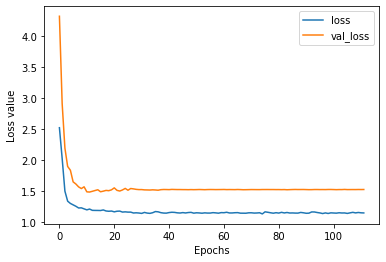

In [172]:
plt.plot(history.get("loss"), label = "loss")
plt.plot(history.get("val_loss"), label = "val_loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.show()

In [174]:
results = LSTM_solar.predict(test_f.iloc[:, :-1])
eval_data = np.array(train.append(test).drop(era5_cols + ["timestamp"], axis=1))
for i in range(test_solar.shape[1]): # for each col
    col_name = test_solar.columns[i]
    err = mase(results[:, i], eval_data[:, i], 2688)
    print(f"MASE of {col_name}: {err}")

90/90 [==============================] - 0s 1ms/step
MASE of Solar0: 3.574171261516675
MASE of Solar1: 6.8698978972702935
MASE of Solar2: 11.243679787068997
MASE of Solar3: 6.11124064346089
MASE of Solar4: 2.228041617449268
MASE of Solar5: 7.968025123112308


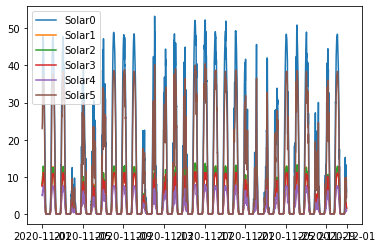

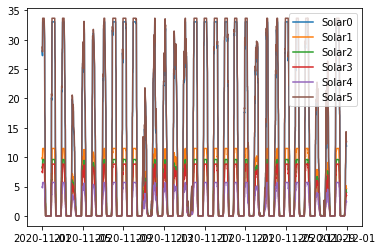

In [175]:
# plot solar TSs
for col in range(6): 
    plt.plot(test_times, test_solar.iloc[:,col], label = test_solar.columns[col])
plt.legend()
plt.show()

for col in range(6): 
    plt.plot(test_times, results[:, col], label = test_solar.columns[col])
plt.legend()
plt.show()